# Extracting the points with TSLA and centroid

In [15]:
import numpy as np, cv2, os, random, math, matplotlib.pyplot as plt, random, pandas as pd 

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
path = "/content/drive/MyDrive/Leaves"
img_files = os.listdir(path)
img_files.sort()

In [18]:
def TSLA_centroid(X,Y,D,N, Cardinal_pts, flag=0):
    T=[]
    Pts_indexes= []
    for i in range(0, Cardinal_pts):
        Pts_ = []
        d=D    
        #print(i) 
        for k in range(0,N):

            A = [[X[i], Y[i]]]
            
            """
                The contours cycle:
                
                imagine that a contour is a closed area in general, so it will arrive a state where we exceed 
                the length of the list of pts set, in this case when i + d exceed len(X) we will take the rest 
                of i + d + 1 divided by len(X):
                
                    r = i + d + 1 - len(X) * q
                    
                so the rest will always stay between [0, len(X) - 1].
                
                The same idea will be applied on i-d when it exceed -len(X) in the negative sens (i-d < -len(X)).
            """
            
            if (i+d > len(X)-1):
                index_plus = (i+d) % len(X)
                A = A + [[ X[index_plus], Y[index_plus] ]]
            else: 
                index_plus = i+d
                A = A + [[ X[index_plus], Y[index_plus] ]]
                
            if (i-d < -len(X)):
                index_minus = (i-d) % -len(X)
                A = A + [[ X[index_minus], Y[index_minus] ]]
            else: 
                index_minus = i-d
                A = A + [[ X[index_minus], Y[index_minus] ]]

            
            """
                calcul the centroid coordinates X and Y
            """
            Centroid = [ (A[0][0] + A[1][0] + A[2][0]) / 3, (A[0][1] + A[1][1] + A[2][1]) / 3 ]
            
            a = math.sqrt( math.pow(A[0][0] - Centroid[0], 2)  +  math.pow(A[0][1] - Centroid[1], 2) )
            _a = math.sqrt( math.pow(A[1][0] - A[2][0], 2)  +  math.pow(A[1][1] - A[2][1], 2) )

            b = math.sqrt( math.pow(A[1][0] - Centroid[0], 2)  +  math.pow(A[1][1] - Centroid[1], 2) )
            _b = math.sqrt( math.pow(A[0][0] - A[2][0], 2)  +  math.pow(A[0][1] - A[2][1], 2) )

            c = math.sqrt( math.pow(A[2][0] - Centroid[0], 2)  +  math.pow(A[2][1] - Centroid[1], 2) )
            _c = math.sqrt( math.pow(A[0][0] - A[1][0], 2)  +  math.pow(A[0][1] - A[1][1], 2) )


            L=[(a, _a), (b, _b), (c, _c)]
            L.sort(key = lambda x: x[0])
            
            """
                Theta calculation of Theta in the case of Centroid should be slightly different:

                    * Like we are taking the angle opposite with the long side out of
                      the centroid
                    
                    * and estimate that angle from the triangle side

                    * In this case we don't know for sure if those caracteristics extracted
                      identify geometricly our triangle
            """

            # Checking if there coincidence between two triangle pts
            if 0 not in np.array(L)[:,0]:

                Theta_cosinus = (L[0][0]**2 + L[1][0]**2 - L[2][1]**2) / (2*L[0][0]*L[1][0])
                if Theta_cosinus > 1:
                    Theta_cosinus = 1 
                elif Theta_cosinus < -1:
                    Theta_cosinus = -1
                Theta = np.arccos(Theta_cosinus)

                # Converting Theta to degrees 
                Theta = Theta * 180 / np.pi
            else:
                Theta = 0

            m = L[0][0]/L[2][0]
            n = L[1][0]/L[2][0]
            T.append(m)
            T.append(n)
            T.append(Theta)
            Pts_ = Pts_ + [[i, index_plus, index_minus]]
            d=d*D

        Pts_indexes = Pts_indexes + [Pts_]

    if flag==0:
        return T, Pts_indexes

    return T

In [20]:
def create_dataset(Cardinal_pts = 128, cycle_number = 6):
    df = pd.DataFrame([])
    for file in img_files:
        imgpath = path + "/" + file
        im_name = './Leaves/' + imgpath.split('/')[-1]

        main_img = cv2.imread(imgpath)
        
        #Preprocessing
        img = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB)
        gs = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        blur = cv2.GaussianBlur(gs, (25,25),0)
        ret_otsu,im_bw_otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        kernel = np.ones((50,50),np.uint8)
        closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)
        
        #Shape features
        contours, image = cv2.findContours(closing,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

        cnt = []
        cnt = [ np.reshape(contours[i], (np.array(contours[i]).shape[0], 2)) for i in range(len(contours)) ]
        cnt = np.concatenate(cnt)

        step = int(len(cnt)/Cardinal_pts)
        X = [ cnt[i][0] for i in range(0, len(cnt), step) ]
        Y = [ cnt[i][1] for i in range(0, len(cnt), step) ]

        T=[]
        T.append(im_name)
        flag = 1
        A=TSLA_centroid(X,Y,2, cycle_number, Cardinal_pts, flag)
        T=T+A
        df_temp = pd.DataFrame([T])
        df = pd.concat([df, df_temp])

    return df

In [21]:
def create_one_image_dataset(Cardinal_pts=128, cycle_number = 6, imgpath = path + '/1024.jpg'):
    df = pd.DataFrame([])

    main_img = cv2.imread(imgpath)
    
    #Preprocessing
    img = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB)
    gs = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gs, (25,25),0)
    ret_otsu,im_bw_otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    kernel = np.ones((50,50),np.uint8)
    closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)
    
    #Shape features
    contours, image = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    cnt = []
    cnt = [ np.reshape(contours[i], (np.array(contours[i]).shape[0], 2)) for i in range(len(contours)) ]
    cnt = np.concatenate(cnt)



    step = int(len(cnt)/Cardinal_pts)
    X = [ cnt[i][0] for i in range(0, len(cnt), step) ]

    Y = [ cnt[i][1] for i in range(0, len(cnt), step) ]

    T=[]
    im_name = './Leaves/' + imgpath.split('/')[-1]
    T.append(im_name)
    flag = 0
    
    A, Pts = TSLA_centroid(X,Y,2, cycle_number, Cardinal_pts, flag)
    T = T + A
    df_temp = pd.DataFrame([T])
    df = pd.concat([df, df_temp]) 

    return df, Pts

In [23]:
Cardinal_pts = 28
inverse = np.log(Cardinal_pts)/np.log(2)
cycle_number = int(inverse) if int(inverse) != inverse else int(inverse) - 1 
dataset = create_dataset(Cardinal_pts, cycle_number)

In [24]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,327,328,329,330,331,332,333,334,335,336
0,./Leaves/1001.jpg,0.201824,0.919613,72.182777,0.284852,0.820223,58.220925,0.370824,0.665359,31.712276,...,7.846735,0.345686,0.755925,53.743808,0.272682,0.798443,48.570142,0.339043,0.666961,13.252685
0,./Leaves/1002.jpg,0.185838,0.815733,8.259438,0.069243,0.953124,48.905368,0.472250,0.564483,30.719960,...,2.878610,0.089774,0.915771,21.192919,0.301785,0.710961,19.912589,0.196072,0.980848,90.075453
0,./Leaves/1003.jpg,0.169919,0.831924,9.265720,0.070560,0.953490,50.339752,0.480690,0.555856,30.602077,...,2.895802,0.082277,0.922769,21.033782,0.292441,0.721198,20.789237,0.204625,0.964268,85.885379
0,./Leaves/1004.jpg,0.205176,0.900821,66.664680,0.666796,0.685014,84.589382,0.358410,0.832436,72.584597,...,11.868000,0.170188,0.890434,53.996304,0.434740,0.664071,50.146626,0.260815,0.766512,30.520925
0,./Leaves/1005.jpg,0.266379,0.825420,55.713631,0.616674,0.888018,98.869232,0.428105,0.912668,91.190564,...,0.064555,0.161224,0.919550,64.332093,0.518795,0.616103,56.667943,0.256507,0.786892,38.710000


In [25]:
dataset.to_csv(f'/content/drive/MyDrive/TSLA/TSLA_centroid_flavia_{Cardinal_pts}_contour_points.csv', index=False)

In [26]:
#from matplotlib.legend_handler import cycleCardinal_pts = 40
inverse = np.log(Cardinal_pts)/np.log(2)
cycle_number = int(inverse) if int(inverse) != inverse else int(inverse) - 1 
one_image, Pts = create_one_image_dataset(Cardinal_pts, cycle_number, imgpath = path + '/1023.jpg')

In [27]:
one_image

,0,1,2,3,4,5,6,7,8,9,...,327,328,329,330,331,332,333,334,335,336
0,./Leaves/1023.jpg,0.278181,0.947267,87.248404,0.328145,0.809897,63.59373,0.387613,0.651998,32.843323,...,0.891929,0.394725,0.713552,53.504707,0.279426,0.815798,55.779352,0.334816,0.670896,12.967044


In [28]:
#int(np.log(32)/np.log(2)) == np.log(32)/np.log(2)
Cardinal_pts = 17
inverse = np.log(Cardinal_pts)/np.log(2)
cycle_number = int(inverse) if int(inverse) != inverse else int(inverse) - 1 
print(f'{Cardinal_pts} * {cycle_number} * {3} = {Cardinal_pts * cycle_number * 3} Columns in one image')

17 * 4 * 3 = 204 Columns in one image


In [29]:
Pts

[[[0, 2, -2], [0, 4, -4], [0, 8, -8], [0, 16, -16]],
 [[1, 3, -1], [1, 5, -3], [1, 9, -7], [1, 17, -15]],
 [[2, 4, 0], [2, 6, -2], [2, 10, -6], [2, 18, -14]],
 [[3, 5, 1], [3, 7, -1], [3, 11, -5], [3, 19, -13]],
 [[4, 6, 2], [4, 8, 0], [4, 12, -4], [4, 20, -12]],
 [[5, 7, 3], [5, 9, 1], [5, 13, -3], [5, 21, -11]],
 [[6, 8, 4], [6, 10, 2], [6, 14, -2], [6, 22, -10]],
 [[7, 9, 5], [7, 11, 3], [7, 15, -1], [7, 23, -9]],
 [[8, 10, 6], [8, 12, 4], [8, 16, 0], [8, 24, -8]],
 [[9, 11, 7], [9, 13, 5], [9, 17, 1], [9, 25, -7]],
 [[10, 12, 8], [10, 14, 6], [10, 18, 2], [10, 26, -6]],
 [[11, 13, 9], [11, 15, 7], [11, 19, 3], [11, 27, -5]],
 [[12, 14, 10], [12, 16, 8], [12, 20, 4], [12, 28, -4]],
 [[13, 15, 11], [13, 17, 9], [13, 21, 5], [13, 0, -3]],
 [[14, 16, 12], [14, 18, 10], [14, 22, 6], [14, 1, -2]],
 [[15, 17, 13], [15, 19, 11], [15, 23, 7], [15, 2, -1]],
 [[16, 18, 14], [16, 20, 12], [16, 24, 8], [16, 3, 0]],
 [[17, 19, 15], [17, 21, 13], [17, 25, 9], [17, 4, 1]],
 [[18, 20, 16], [18, 22,

# Design the first triangles and their Centroids

(1, 2848, 2)
137 147


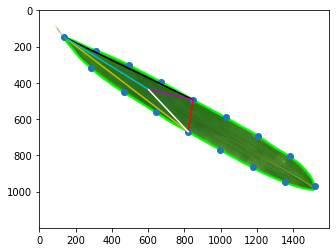

In [32]:
imgpath = path + "/1023.jpg"

Ms = []
Ns = []

main_img = cv2.imread(imgpath)

#Preprocessing
img = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB)
gs = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
blur = cv2.GaussianBlur(gs, (25,25),0)
ret_otsu,im_bw_otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
kernel = np.ones((50,50),np.uint8)
closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)

#Shape features
contours, hierarchy = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

contour_lentgth_order = [ (len(contours[i]), i) for i in range(len(contours)) ]
contour_lentgth_order.sort(key= lambda x: x[0])

cnt = []
cnt = [ np.reshape(contours[i], (np.array(contours[i]).shape[0], 2)) for i in range(len(contours)) ]
print(np.array(cnt).shape)
cnt = np.concatenate(cnt)

cardinal = 4
X = [ cnt[i][0] for i in range(0,len(cnt),int(len(cnt)/(2**cardinal))) ]
Y = [ cnt[i][1] for i in range(0,len(cnt),int(len(cnt)/(2**cardinal))) ]

plottedContour = cv2.drawContours(img,contours,-1,(0,255,0),10)
implot = plt.imshow(plottedContour,cmap="Greys_r")
plt.plot(X,Y,'o')
print(X[0], Y[0])

steps = [2**i for i in range(1, cardinal+1)]
for i in steps:
    if i == 2**(cardinal - 2): # this if is intend in order to plot one triange, and also Look the line behind it I commented that For loop
        #for start in range(len(X)):
          start = 0

          if (start + i >len(X)-1):
              index_plus = (start + i) % len(X)
          else: 
              index_plus = start + i
              
          if (start - i < -len(X)):
              index_minus = (start - i) % -len(X)
          else: 
              index_minus = start - i

          Centroid = [ (X[start] + X[index_plus] + X[start - i]) / 3, (Y[start] + Y[index_plus] + Y[start - i]) / 3 ]
          AB_X, AB_Y = [X[start], X[index_plus]], [Y[start], Y[index_plus]]
          AC_X, AC_Y = [X[start], X[index_minus]], [Y[start], Y[index_minus]]
          BC_X, BC_Y = [X[index_plus], X[index_minus]], [Y[index_plus], Y[index_minus]]

          AG_X, AG_Y = [X[start], Centroid[0]], [Y[start], Centroid[1]]
          CG_X, CG_Y = [Centroid[0], X[index_minus]], [Centroid[1], Y[index_minus]]
          BG_X, BG_Y = [X[index_plus], Centroid[0]], [Y[index_plus], Centroid[1]]

          ag = math.sqrt( math.pow(AG_X[0] - AG_X[1], 2)  +  math.pow(AG_Y[0] - AG_Y[1], 2) )
          bg = math.sqrt( math.pow(BG_X[0] - BG_X[1], 2)  +  math.pow(BG_Y[0] - BG_Y[1], 2) )
          cg = math.sqrt( math.pow(CG_X[0] - CG_X[1], 2)  +  math.pow(CG_Y[0] - CG_Y[1], 2) )

          Sides = [ag, bg, cg]
          Sides.sort()

          #m = Sides[0]/Sides[2]
          #n = Sides[1]/Sides[2]
          #Ms.append(m)
          #Ns.append(n)

          plt.plot(BC_X, BC_Y, color='r')
          plt.plot(AB_X, AB_Y, color='y')
          plt.plot(AC_X, AC_Y, color='k')

          plt.plot(AG_X, AG_Y, color='c')
          plt.plot(CG_X, CG_Y, color='m')
          plt.plot(BG_X, BG_Y, color='w')
          #X_ = [ 149 for i in range(0,len(cnt),int(len(cnt)/(2**cardinal))) ]
          #Y_ = [ cnt[i][1] for i in range(0,len(cnt),int(len(cnt)/(2**cardinal))) ]
          #plt.plot(X_, Y_)

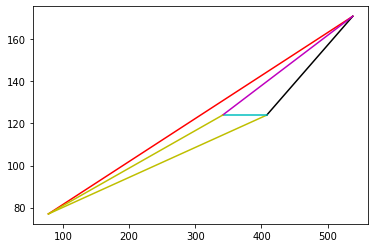

In [35]:
A = np.array([[408, 124], [78, 77], [538, 171]])
X = A[:,0]
Y = A[:,1]
Centroid = [ (X[0] + X[1] + X[2]) / 3, (Y[0] + Y[1] + Y[2]) / 3 ]

AB_X, AB_Y = [X[0], X[1]], [Y[0], Y[1]]
AC_X, AC_Y = [X[0], X[2]], [Y[0], Y[2]]
BC_X, BC_Y = [X[1], X[2]], [Y[1], Y[2]]

AG_X, AG_Y = [X[0], Centroid[0]], [Y[0], Centroid[1]]
CG_X, CG_Y = [Centroid[0], X[2]], [Centroid[1], Y[2]]
BG_X, BG_Y = [X[1], Centroid[0]], [Y[1], Centroid[1]]

ag = math.sqrt( math.pow(AG_X[0] - AG_X[1], 2)  +  math.pow(AG_Y[0] - AG_Y[1], 2) )
bg = math.sqrt( math.pow(BG_X[0] - BG_X[1], 2)  +  math.pow(BG_Y[0] - BG_Y[1], 2) )
cg = math.sqrt( math.pow(CG_X[0] - CG_X[1], 2)  +  math.pow(CG_Y[0] - CG_Y[1], 2) )

plt.plot(BC_X, BC_Y, color='r')
plt.plot(AB_X, AB_Y, color='y')
plt.plot(AC_X, AC_Y, color='k')

plt.plot(AG_X, AG_Y, color='c')
plt.plot(CG_X, CG_Y, color='m')
plt.plot(BG_X, BG_Y, color='y')
